### AMOL SPEX dust model 

In order to study the dust in the spectra of X-ray binaries we want to analyze the dust with a dedicated model. This model is called amol and contains the edges of lab measurements of interstellar dust analogues, which were converted to interstellar dust models. 

In this example we use the spectrum of GX 17+2 to test the amol model and to try and fit the Si K-edge. 

We first import numpy and matplotlib and define a function which enables us to plot the photon flux. 

In [2]:
import numpy
import matplotlib.pyplot as plt

In [4]:
# Define a function to plot spectrum in photon flux
def plot_flux(xlog=False,ylog=False,wave=False):
    # Get plot data
    (data,plt) = s.plot_data(wave=wave,show=False)
    plt.clf()    
    
    fig, ax = plt.subplots()
    
    # Loop over instruments and regions
    for i in numpy.arange(data.ninst):
        for r in numpy.arange(data.inst[i].nreg):
            tabdata = data.inst[i].reg[r].tabdata
            
            # Calculate flux spectrum and other plotting arrays
            xerror = tabdata['X_ctr'] - tabdata['X_low']
            ydata = tabdata['Data'] * tabdata['1/Area']
            yerror = tabdata['Error'] * tabdata['1/Area']
            model = tabdata['Model'] * tabdata['1/Area']
            
            ax.errorbar(tabdata['X_ctr'], ydata, xerr=xerror, yerr=yerror, marker='', ls='', c='k')
            ax.step(tabdata['X_upp'], model, where='pre',c='r')
            
            if xlog:
                ax.set_xscale('log')

            if ylog:
                ax.set_yscale('log')
    
    # Set plot labels and format axes
    if wave:
        plt.xlabel('Wavelength ({0})'.format(tabdata['X_ctr'].unit.to_string('latex_inline')))
    else:
        plt.xlabel('Energy ({0})'.format(tabdata['X_ctr'].unit.to_string('latex_inline')))

    plt.ylabel('Flux ({0})'.format(ydata.unit.to_string('latex_inline')))

    if xlog:
        formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
        ax.xaxis.set_major_formatter(formatter)   
    
    return plt

In [5]:
from pyspex import spex
s=spex.Session()

 Welcome idies to SPEX version 3.07.03

 NEW in this version of SPEX: 
01-12-2022 Fixed issue with plot cap command
05-12-2022 Fixed issue with knak model
22-03-2023 Fixed issue with treatment of bad quality bins in trafo
23-03-2023 Fixed small issues in the pyspex interface

 Currently using SPEXACT version 2.07.00. Type `help var calc` for details.


In [6]:
%matplotlib inline

Here we read in the data from Chandra HETG. You can find the data in the spectra folder. Load the res and spo file of GX 17+2. The Chandra HETG data contain both the HEG and MEG grating spectra. The MEG spectrum is in region 1, the HEG in region 2 and both spectra are stored in the same sector, sector 1. 

In [7]:
s.data('gx17/GX_17.res','gx17/GX_17.spo')

0

Plot the spectra. 

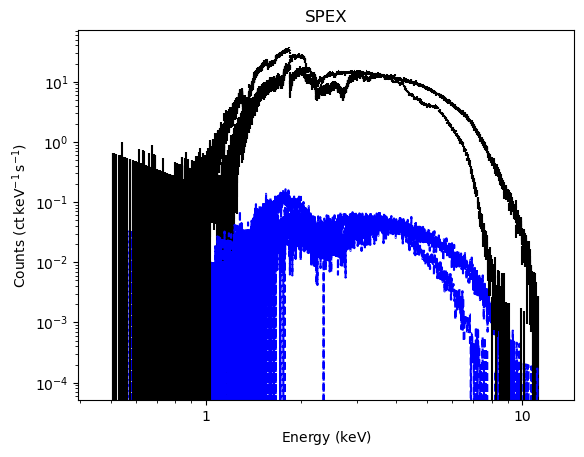

In [8]:
plt = s.plot_data(xlog=True, ylog=True, show=True)

Before fitting the edge, it is important to bin the spectrum. Ignore parts of the data where the grating is not sensitive/ where the telescope has little effective area: 
ign 7:1e4 u k  (here you ignore all the data beyond 7 keV)
ign 1e-4:1.3 u k (here you ignore all the data below 1 keV)
ign ins 1 region 2 1.5:1e4 u k ( here you ignore all the data of the MEG grating about 1.5 kev). We take this last step because the MEG grating is heavily depleted due to pile-up. The command s.bin(1, 1, 1, 7, 3, 'kev') rebins the data in this region with a factor of 3.

In [9]:
s.ignore(1, 1, 7.0, 1e4, 'kev')
s.ignore(1, 2, 1.5, 1e4, 'kev')
s.ignore(1, 1, 1e-4, 1.3, 'kev')
s.ignore(1, 2, 1e-4, 1.3, 'kev')
s.bin(1, 2, 1, 7, 3, 'kev')
s.bin(1, 1, 1, 7, 3, 'kev')

Plot again and take a look at the resulting spectrum.

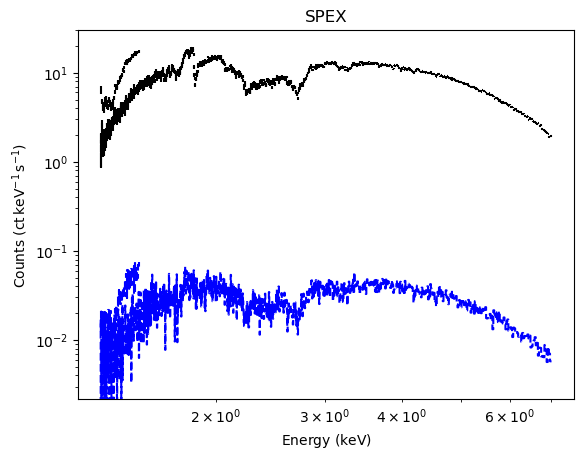

In [10]:
plt = s.plot_data(xlog=True, ylog=True, show=True)

Now we have correctly binned the spectrum. The Si K-edge around 1.8 keV is well sampled. Since we will closely look at variation in the area around the edge, this needs to be . Sometimes it may help to sample the data around the edge a bit courser to increase the number of photons in the bin. In this way we can reduce uncertainties on the measurements, but you pay for it in resolution, so it is only useful when you don’t need this information. 

#### We can continue by defining models:
We are modelling an X-ray binary, so we can either use a few simple models, 
such as a blackbody and power law model or we can make it a bit more sophisticated 
and choose a disk blackbody model in combination with a comptonization model. Here we will use a 
bb and po model to describe the source. These models take the least computational time, but they are not necessarily 
the best fitting model for the binary. 

In [11]:
s.com('bb')
s.com('po')

 You have defined    1 component.
 You have defined    2 components.


The light is then absorbed by cold gas along the line of sight. 
We define this as a “hot” model with a cold (i.e. very low) temperature. 
You cannot put the temperature to zero, because then SPEX cannot calculate anything anymore. 
So we define: com hot

In [12]:
s.com('hot')

 You have defined    3 components.


We set a distance: dist 12.6 kpc in this case

In [13]:
s.dist(1, 12.6, 'kpc')

 Distances assuming H0 =  70.0 km/s/Mpc, Omega_m = 0.300 Omega_Lambda = 0.700 Omega_r = 0.000
Sector       m      A.U.        ly        pc       kpc       Mpc  redshift        cz   age(yr)
----------------------------------------------------------------------------------------------
   1 3.888E+20 2.599E+09 4.110E+04 1.260E+04   12.6000 1.260E-02    0.0000       0.9 4.110E+04
----------------------------------------------------------------------------------------------



We then relate the models, so SPEX knows in what order it needs to use them:
com rel 1:2 3 (if you use SPEX from the command line)
where 1 is the bb model, 2 the po model and 3 the hot model.

In [14]:
s.com_rel(1, 1, numpy.array([3]))

In [15]:
s.com_rel(1, 2, numpy.array([3]))

With the command: model show, you can inspect the model

In [16]:
s.command('model show')

--------------------------------------------------------------------------------
 Number of sectors         :     1
 Sector:    1 Number of model components:     3
    Nr.    1: bb  [3 ]
    Nr.    2: pow [3 ]
    Nr.    3: hot


0

We now need to set some values to the models. 
This is a bit of trial and error usually. 
Try values that already seem to fit the X-ray binary, 
but still leave freedom to the fit to find a best-fitting set of values. 
For this X-ray binary I give you some starting values:

In [17]:
s.par(1, 1, 't', 1.5, thawn=True)
s.par(1, 1, 'n', 1.e-7, thawn=True)

s.par(1, 2, 'n', 100, thawn = True)
s.par(1, 2, 'gamm', 1.5, thawn = True)

s.par(1, 3, 'nh', 2.4e-2, thawn = True)
s.par(1, 3, 't', 8e-6, thawn = False)

Calculate with s.calc(), plot the result and inspect if you think the model is good enough to fit.  

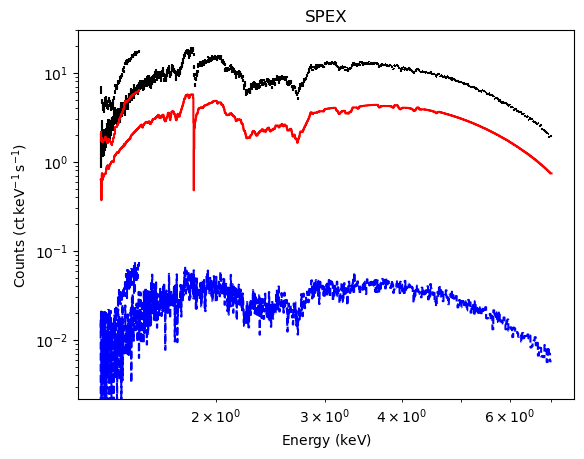

In [18]:
s.calc()
plt = s.plot_data(xlog=True, ylog=True, show=True)

We can now also plot the flux to inspect the observation further. 

<Figure size 640x480 with 0 Axes>

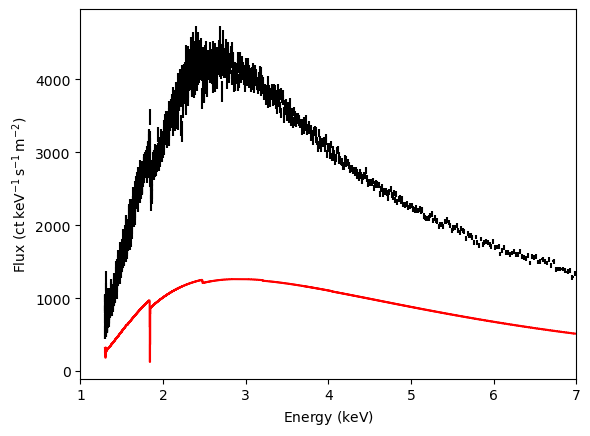

In [19]:
plt=plot_flux()
plt.xlim(1.0,7.0)
plt.show()

With the command s.fit(), you start fitting. If you use SPEX from the command line, 
you can use the command fit print 1 to see all the intermediate fitting steps and inspect how the fit converges.

In [20]:
s.fit()
print(s.fit_cstat())

 fit iter  100                                                   
  1.140309E+06          6  1.000E-07   1.50       100.       1.50      2.400E-02
 You cannot plot this frame since nothing is defined
 
   391305.             13  1.293E-07   1.63       122.       1.32      2.112E-02
 You cannot plot this frame since nothing is defined
 
   26944.3             19  1.936E-07   1.44       193.       1.07      2.004E-02
 You cannot plot this frame since nothing is defined
 
   18965.7             26  2.392E-07   1.27       233.       1.15      2.156E-02
 You cannot plot this frame since nothing is defined
 
   14680.6             32  3.380E-07   1.12       317.       1.36      2.522E-02
 You cannot plot this frame since nothing is defined
 
   7982.40             38  4.462E-07   1.02       414.       1.49      2.794E-02
 You cannot plot this frame since nothing is defined
 
   5270.32             44  6.051E-07  0.888       472.       1.51      2.929E-02
 You cannot plot this frame sin

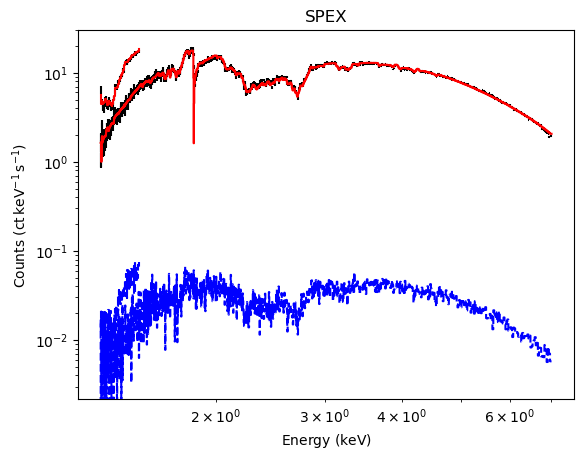

In [21]:
plt = s.plot_data(xlog=True, ylog=True, show=True)

Let's take a look at the area around the Silicon K-edge: 

<Figure size 640x480 with 0 Axes>

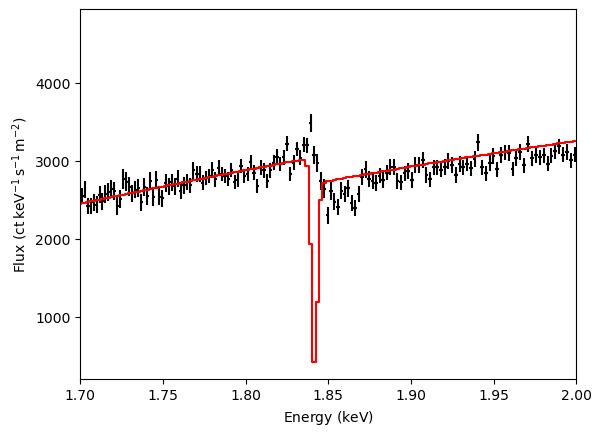

In [22]:
plt=plot_flux()
plt.xlim(1.7,2.0)
plt.show()

# Amol 
If you are happy with the fit of the continuum (when is a fit a good fit?) , you can add another model. We now want to specifically fit the dust features of the edges. 
In this spectrum we observe a prominent Si K-edge feature. 
Define the amol model and relate the models again. 

In [23]:
s.com('amol')

 You have defined    4 components.


In [24]:
s.com_rel(1, 1, numpy.array([3,4]))
s.com_rel(1, 2, numpy.array([3,4]))

With par sho you can inspect the parameters in the amol model. 
The values i1 to i4 are slots where you can input different dust species. 
For instance the value 4103 stands for olivine and 4234 for pyroxene. 
Try if you can fit these silicate models to the spectrum. 
A full list is available in SPEX, this index file is also stored in this repository. 
The values n1 to n4 are the corresponding values of the abundances of these dust species. 
Usually a starting value of 1e-7 is a good first guess. 

In [25]:
s.par(1, 4, 'i1', 4103, thawn = False)
s.par(1, 4, 'n1', 1e-7, thawn = True)
s.par(1, 4, 'i2', 4234 , thawn = False)
s.par(1, 4, 'n2', 1e-7, thawn = True)

Because silicon, magnesium, oxygen and iron are now depleted into dust, 
we need to make some changes to the hot model. 
The elements should be thawned and we will lower the default gas values
and implement ranges for the depletion. 

In [26]:
s.par(1, 3, '08', 0.7, thawn = True)
s.par(1, 3, '12', 0.1, thawn = True)
s.par(1, 3, '14', 0.1, thawn = True)
s.par(1, 3, '26', 0.1, thawn = True)
s.par_free(1, 3, '08')
s.command('par 1 3 08 range 0.58 0.98')
s.command('par 1 3 12 range 0.05 0.98')
s.command('par 1 3 14 range 0.04 0.59')
s.command('par 1 3 26 range 0.03 0.30')
s.calc()

Try to fit the spectrum and zoom in on the Si K-edge. 
Can you see the XAFS? What do you need to change in the cold gas model (hot)? Think about depletion!

In [27]:
s.fit()
print(s.fit_cstat())

 fit iter  100                                                   
   52173.3             12  2.697E-06  0.845       47.3      0.338      2.203E-02
                0.700      0.100      0.100      0.100      1.000E-07  1.000E-07
 You cannot plot this frame since nothing is defined
 
   18210.4             25  2.798E-06  0.814       74.5      0.617      1.700E-02
                0.978      5.000E-02  4.000E-02  0.300      5.116E-07  4.582E-07
 You cannot plot this frame since nothing is defined
 
   4739.93             38  2.850E-06  0.812       78.3      0.581      1.900E-02
                0.980      5.000E-02  4.000E-02  0.300      5.593E-07  4.993E-07
 You cannot plot this frame since nothing is defined
 
   1559.05             50  2.880E-06  0.800       95.3      0.689      2.134E-02
                0.980      5.000E-02  4.000E-02  0.300      5.954E-07  4.979E-07
 You cannot plot this frame since nothing is defined
 
   1426.20             63  2.890E-06  0.798       99.3      0.

<Figure size 640x480 with 0 Axes>

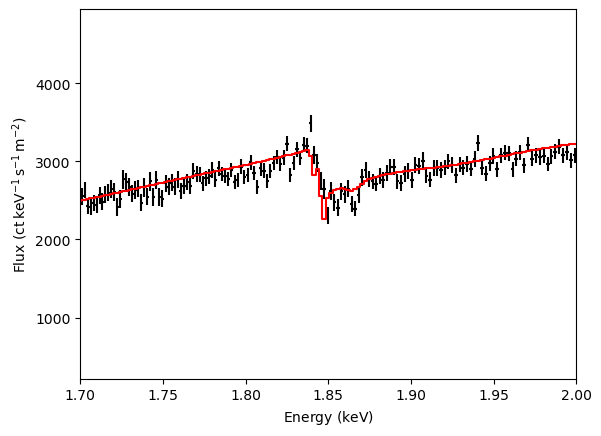

In [28]:
plt=plot_flux()
plt.xlim(1.7,2.0)
plt.show()